In [10]:
import numpy as np
from tensorflow import keras
import glob
import cv2
from keras.applications.mobilenet import preprocess_input

In [11]:
# read one image to veify size
test_images = glob.glob('test/*/*.jpg')
train_images = glob.glob('train/*/*.jpg')

single_image = test_images[0]
img = cv2.imread(single_image)
h,w,c = img.shape
input_shape=(h,w,c)

print('input shape:', input_shape)

input shape: (224, 224, 3)


In [12]:
# define the model
def setup_model(input_shape):
    
    model = keras.applications.MobileNet(include_top=False, input_shape=input_shape)
    # make all layers are not trainable
    
    for layer in model.layers:
        layer.trainable = False
        
    model.summary()
    
    # following example: set layers from 20 to be trainable
    for layer in model.layers[20:]:
        layer.trainable=True
 
    x = model.output
    
    x=keras.layers.GlobalAveragePooling2D()(x)
    x=keras.layers.Dense(1024,activation='relu')(x) 
    x=keras.layers.Dropout(0.5)(x)
    x=keras.layers.Dense(1024,activation='relu')(x) 
    x=keras.layers.Dropout(0.5)(x)
    x=keras.layers.Dense(512,activation='relu')(x)
    x=keras.layers.Dropout(0.5)(x)
    x=keras.layers.Dense(2,activation='softmax')(x) #final layer with softmax activation
    
    mymodel = keras.models.Model(inputs=model.input , outputs=x)
    #opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
    mymodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return mymodel


In [13]:
model = setup_model(input_shape)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pw_1 (Conv2D)           (None, 112, 112, 64)      2048      
_________________________________________________________________
conv_pw_1_bn (BatchNormaliza (None, 112, 112, 64)      256       
__________

In [14]:
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [15]:
datagen=keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size=8
                                                
train_iter = datagen.flow_from_directory('train/',class_mode='categorical', target_size=(h,h), color_mode='rgb', shuffle=True, batch_size=batch_size)
test_iter = datagen.flow_from_directory('test/',class_mode='categorical', target_size=(h,h), color_mode='rgb', shuffle=True, batch_size=batch_size)

print('length of iterations for train,test:', len(train_iter), len(test_iter))
                                                     

Found 18710 images belonging to 2 classes.
Found 6236 images belonging to 2 classes.
length of iterations for train,test: 2339 780


In [16]:
#train the model with train data and check each epoch against test data
fit_history = model.fit_generator(train_iter, 
                                  steps_per_epoch=len(train_iter), 
                                  workers=4,
                                  epochs=20,
                                  validation_data=test_iter,
                                  validation_steps=len(test_iter)
                    )

Epoch 1/20
2339/2339 [==============================] - 226s 96ms/step - loss: 0.2951 - acc: 0.8970 - val_loss: 0.3737 - val_acc: 0.8890
Epoch 2/20
2339/2339 [==============================] - 223s 95ms/step - loss: 0.2054 - acc: 0.9263 - val_loss: 0.2087 - val_acc: 0.9344
Epoch 3/20
2339/2339 [==============================] - 223s 95ms/step - loss: 0.1803 - acc: 0.9384 - val_loss: 0.3081 - val_acc: 0.8913
Epoch 4/20
2339/2339 [==============================] - 223s 95ms/step - loss: 0.1441 - acc: 0.9523 - val_loss: 0.2478 - val_acc: 0.9177
Epoch 5/20
2339/2339 [==============================] - 222s 95ms/step - loss: 0.1335 - acc: 0.9560 - val_loss: 0.1370 - val_acc: 0.9540
Epoch 6/20
2339/2339 [==============================] - 222s 95ms/step - loss: 0.1248 - acc: 0.9588 - val_loss: 0.1214 - val_acc: 0.9545
Epoch 7/20
2339/2339 [==============================] - 221s 95ms/step - loss: 0.1028 - acc: 0.9653 - val_loss: 0.1318 - val_acc: 0.9440
Epoch 8/20
2339/2339 [===================

In [17]:
model.save('mobile_model.h5')

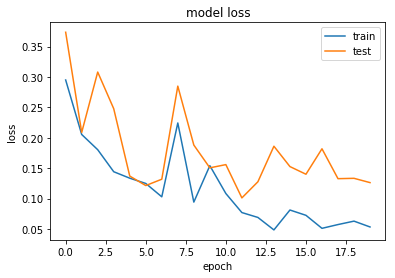

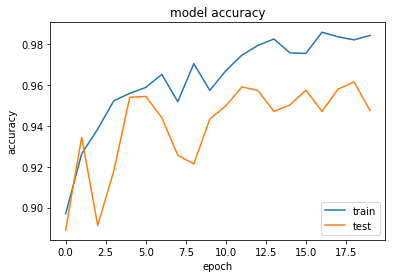

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt

# show procession of training...
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(fit_history.history['acc'])
plt.plot(fit_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
plt.close()